# Imports

In [ ]:
import numpy as np
import pandas as pd
import neurokit2 as nk

import h5py
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models
import tensorflow as tf
import glob

# Define Paths

In [ ]:
path_PROJECT = '' #Enter directory here
path_DATA_512 = path_PROJECT+'/data_512/'
path_DATA_1024 = path_PROJECT+'/data_1024/'
path_DATA_2048 = path_PROJECT+'/data_2048/'
path_DATA_4096 = path_PROJECT+'/data_4096/'

path_SAVE = path_PROJECT+'/outputs/'

# Load Data

In [ ]:
#Load VCG data
hf = h5py.File(path_DATA_512+'vs_xp_all.h5', 'r')
data = np.transpose(hf['data'][:,:,:],(2,1,0))
hf.close()

#Load recording metadata
dfMeta = pd.read_csv(path_DATA_512+'meta.txt')
dfMeta['File_id']=dfMeta['Sub_id'].astype(str)+dfMeta['Day_id'].astype(str)+dfMeta['Test_type']+dfMeta['Test_num'].astype(str)

#Load biopac reference data
hf = h5py.File(path_DATA_512+'bio.h5', 'r')
data_bio = np.transpose(hf['data'][:,:,:],(2,1,0)) #biopac data: [ecg, icg, ppg, nibp, airflow]
hf.close()


# Definitions

## Dataset loader

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):
    def __init__(self, data, labels,batch_size,shuffle=True,**kwargs):
        super().__init__(**kwargs)
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        low = idx*self.batch_size
        high = min(low+self.batch_size,len(self.data))
        sample = self.data[low:high]
        label = self.labels[low:high]
        return sample, label
    
    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.data))
            np.random.shuffle(indices)
            self.data = self.data[indices]
            self.labels = self.labels[indices]

## Split and Normalize

In [ ]:
def normalize_beats(input_signal):
    u = input_signal.mean(axis=1,keepdims=True)
    std = input_signal.std(axis=1,keepdims=True)
    output_signal = (input_signal-u)/std
    return output_signal

def split_data(data_train,target,dfMeta,split_type = 'loo',sub_num = 0, test_size = 0.8, normalize_inputs = True, normalize_outputs = True, normalize_output_beats = True, normalize_input_beats = False):
    params = {}
    
    if split_type == 'loo': #Test on a specific subject
        id_test = dfMeta.Sub_id.unique()[sub_num]
        inds_test = dfMeta['Sub_id'].isin(id_test)
        inds_train = ~inds_test
    
    elif split_type =='subs': # Test on unseen subjects
        train_ids, test_ids = train_test_split(dfMeta.Sub_id.unique(),shuffle=True, random_state=0,test_size=test_size)
        inds_train = dfMeta['Sub_id'].isin(train_ids)
        inds_test = dfMeta['Sub_id'].isin(test_ids)
    
    elif split_type == 'random': # Random shuffle -> Bad for health applications as subjects are mixed
        inds_train, inds_test = train_test_split(dfMeta.index.values,random_state=0,shuffle=True,test_size=test_size)
    
    
    x_train = data_train[inds_train]
    x_test = data_train[inds_test]
    y_train = target[inds_train]
    y_test = target[inds_test]

    u_data = x_train.mean(axis=(0,1)) # Get average for each axis of data
    sd_data = x_train.std(axis=(0,1))

    u_target = y_train.mean(axis=(0,1))
    sd_target = y_train.std(axis=(0,1))
    
    params['u_data'] = u_data
    params['sd_data'] = sd_data
    params['u_target'] = u_target
    params['sd_target'] = sd_target
    params['inds_train'] = inds_train
    params['inds_test'] = inds_test
    
    # Normalize across all input signals
    if normalize_inputs: 
        x_train = (x_train-u_data)/sd_data
        x_test = (x_test-u_data)/sd_data
    
    # Normalize across all output signals
    if normalize_outputs: 
        y_train = (y_train-u_target)/sd_target
        y_test = (y_test-u_target)/sd_target
    
    # Normalize across each output segment
    if normalize_output_beats: 
        y_train = normalize_beats(y_train)
        y_test = normalize_beats(y_test)
    
    # Normalize across each input segment
    if normalize_input_beats: 
        x_train = normalize_beats(x_train)
        x_test = normalize_beats(x_test)
    
    return x_train, x_test, y_train, y_test, params

## Model Architecture

In [ ]:
def conv_block_1d(x, filters, kernel_size=4, strides=2, padding='same', batchnorm=True):
    x = layers.Conv1D(filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    return x

def deconv_block_1d(x, skip_input, filters, kernel_size=4, strides=2, padding='same'):
    x = layers.Conv1DTranspose(filters, kernel_size=kernel_size, strides=strides, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Concatenate()([x, skip_input])
    return x

def pix2pix_generator_1d_8(input_shape, output_channels):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    enc1 = conv_block_1d(inputs, 64, batchnorm=False)
    enc2 = conv_block_1d(enc1, 128)
    enc3 = conv_block_1d(enc2, 256)
    enc4 = conv_block_1d(enc3, 512)
    enc5 = conv_block_1d(enc4, 512)
    enc6 = conv_block_1d(enc5, 512)
    enc7 = conv_block_1d(enc6, 512)
    enc8 = conv_block_1d(enc7, 512)

    # Decoder
    dec1 = deconv_block_1d(enc8, enc7, 512)
    dec2 = deconv_block_1d(dec1, enc6, 512)
    dec3 = deconv_block_1d(dec2, enc5, 512)
    dec4 = deconv_block_1d(dec3, enc4, 512)
    dec5 = deconv_block_1d(dec4, enc3, 256)
    dec6 = deconv_block_1d(dec5, enc2, 128)
    dec7 = deconv_block_1d(dec6, enc1, 64)  

    outputs = layers.Conv1DTranspose(output_channels, kernel_size=4, strides=2, padding='same', activation='linear')(dec7)  # (batch, len, output_channels)

    model = models.Model(inputs, outputs)
    return model


def pix2pix_discriminator_1d(input_shape, target_shape):
    input_sequence = layers.Input(shape=input_shape)
    target_sequence = layers.Input(shape=target_shape)

    x = layers.Concatenate()([input_sequence, target_sequence])

    x = conv_block_1d(x, 64, strides=2, batchnorm=False)  # (batch, 256, 64)
    x = conv_block_1d(x, 128, strides=2)  # (batch, 128, 128)
    x = conv_block_1d(x, 256, strides=2)  # (batch, 64, 256)
    x = conv_block_1d(x, 512, strides=1)  # (batch, 64, 512)

    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    outputs = layers.Conv1D(1, kernel_size=4, strides=1, padding='same')(x)

    model = models.Model([input_sequence, target_sequence], outputs)
    return model

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    target = tf.cast(target, tf.float32)
    gen_output = tf.cast(gen_output, tf.float32)
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (100 * l1_loss)
    return total_gen_loss

class pix2pix_model(tf.keras.Model):
    def __init__(self, 
                 discriminator, 
                 generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")


    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(pix2pix_model, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
    
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self,data):
        input_sequence, target_sequence = data
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_output = self.generator(input_sequence, training=True)
            disc_real_output = self.discriminator([input_sequence, target_sequence], training=True)
            disc_generated_output = self.discriminator([input_sequence, gen_output], training=True)

            gen_loss = self.g_loss_fn(disc_generated_output, gen_output, target_sequence)
            disc_loss = self.d_loss_fn(disc_real_output, disc_generated_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        self.d_loss_metric.update_state(disc_loss)
        self.g_loss_metric.update_state(gen_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

    def call(self, inputs, training=False):
        if isinstance(inputs, (list, tuple)):
            input_sequence = inputs[0]
        else:
            input_sequence = inputs
        return self.generator(input_sequence, training=training)


# Run

## Train

In [ ]:
subs_kfold = range(20)
y_test_all = []
y_pred_test_all = []
df_tests = []
n_epochs = 5
batch_size = 32
#Loop through subjects
for subs_now in subs_kfold:
    #Split and normalize data    
    x_train, x_test, y_train, y_test, params = split_data(data, 
                                                      np.concatenate((np.expand_dims(data_bio[:,:,0],axis=2),np.expand_dims(data_bio[:,:,3],axis=2),np.expand_dims(data_bio[:,:,1],axis=2),np.expand_dims(data_bio[:,:,2],axis=2)),axis=2),
                                                      dfMeta,split_type='loo',sub_num = [subs_now],
                                                      normalize_inputs=True, normalize_outputs = True, 
                                                      normalize_output_beats=True,
                                                      normalize_input_beats=True
                                                      )
                                                    
    
    dataset_p2p = CustomDataset(x_train,y_train,batch_size=batch_size)

    input_shape = x_train[0].shape
    target_shape = y_train[0].shape
    output_channels = target_shape[1]

    #Set up model
    generator = pix2pix_generator_1d_8(input_shape, output_channels)
    discriminator = pix2pix_discriminator_1d(input_shape, target_shape)
    gan_model = pix2pix_model(generator=generator,discriminator=discriminator)
    generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    gan_model.compile(d_optimizer = discriminator_optimizer,g_optimizer = generator_optimizer,d_loss_fn = discriminator_loss,g_loss_fn = generator_loss)
    
    #Train and Eval
    hist = gan_model.fit(dataset_p2p,epochs=n_epochs)
    y_pred_test = gan_model.generator.predict(x_test)
    np.savez(path_DATA_512+'saved_data/20240920_preds_norm_5e_sub'+str(subs_now)+'.npz',
           y_pred_test = y_pred_test,
           y_test = y_test,
           dfMeta_now = dfMeta.loc[params['inds_test']])
    n_outputs = 4
    r_test = np.zeros(n_outputs)
    for i in range(n_outputs):
        r_test[i] = np.corrcoef(y_test[:,:,i].flatten(),y_pred_test[:,:,i].flatten())[0,1]
    print(subs_now, r_test)
    del dataset_p2p

## Results

### Load Saved Data

In [ ]:
y_pred_loaded = []
y_test_loaded = []
dfs_loaded = []
files_load = glob.glob(path_DATA_512+'saved_Data/20240920*')
str_cols = ['Sub_id', 'Day_id', 'Test_type', 'Test_num', 'Beat_num', 'ts_start','SBP', 'DBP', 'PP', 'MAP', 'File_id']
for file_load in files_load:
    data_load = np.load(file_load,allow_pickle=True)
    y_pred_loaded.append(data_load['y_pred_test'])
    y_test_loaded.append(data_load['y_test'])
    dfs_loaded.append(pd.DataFrame(data=data_load['dfMeta_now'],columns=str_cols))

In [ ]:
# ECG, NIBP, ICG, PPG
n_outputs = 4
rs = []
maes = []
for k in range(20):
    r_test = np.zeros(n_outputs)
    mae_test = np.zeros(n_outputs)
    for i in range(n_outputs):
        r_test[i] = np.corrcoef(y_test_loaded[k][:,:,i].flatten(),y_pred_loaded[k][:,:,i].flatten())[0,1]
        mae_test[i] = mean_absolute_error(y_test_loaded[k][:,:,i],y_pred_loaded[k][:,:,i])
    rs.append(r_test)
    maes.append(mae_test)

In [40]:
print('Metric \t','ECG','NIBP','ICG','PPG')
print('Median PCC ',np.round(np.median(np.vstack(rs),axis=0),3))
print('Median MAE ',np.round(np.median(np.vstack(maes),axis=0),3))

Metric 	 ECG NIBP ICG PPG
Median PCC  [0.808 0.907 0.833 0.929]
Median MAE  [0.309 0.275 0.401 0.255]


### Figure 5 - Box plot

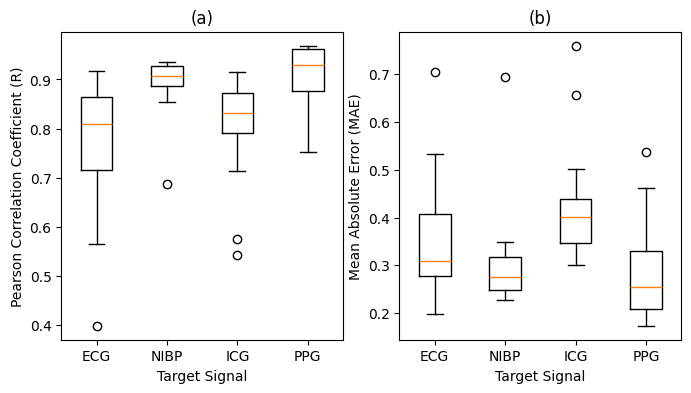

In [48]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.boxplot(np.vstack(rs), labels = ['ECG', 'NIBP', 'ICG', 'PPG'])
plt.ylabel('Pearson Correlation Coefficient (R)')
plt.xlabel('Target Signal')
plt.title('(a)')
plt.subplot(1,2,2)
plt.boxplot(np.vstack(maes), labels = ['ECG', 'NIBP', 'ICG', 'PPG'])
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Target Signal')
plt.title('(b)')
plt.show()

### Figure 4 - Results plot

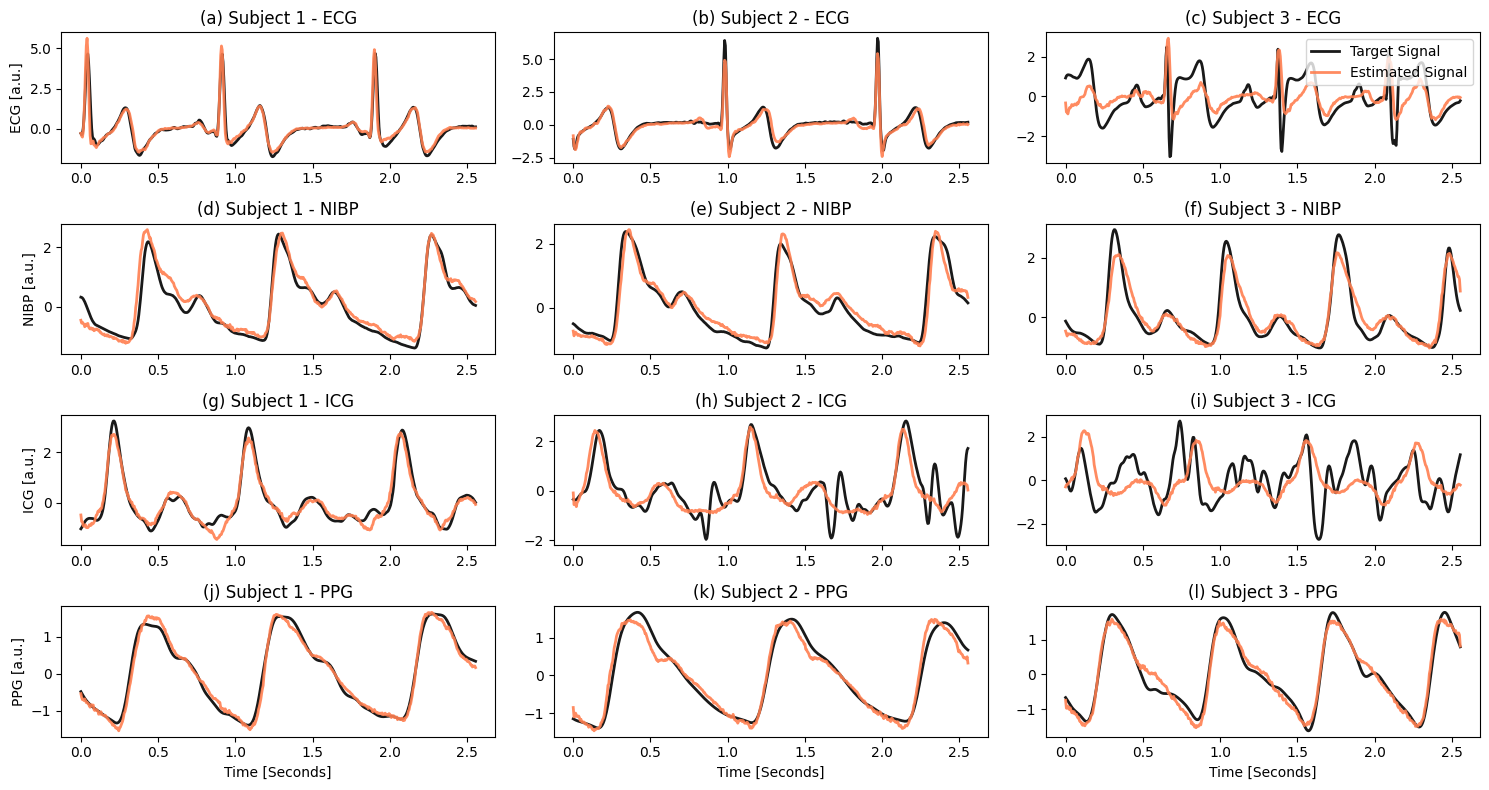

In [ ]:
fig1 = plt.figure(figsize=(15,8))
i_plot = 1
beat_nums = [45,56,65]
sub_nums = [0,11,12]
y_labels = ['ECG [a.u.]','NIBP [a.u.]','ICG [a.u.]','PPG [a.u.]']
title_strs = ['(a) Subject 1 - ECG','(b) Subject 2 - ECG','(c) Subject 3 - ECG',
              '(d) Subject 1 - NIBP','(e) Subject 2 - NIBP','(f) Subject 3 - NIBP',
              '(g) Subject 1 - ICG','(h) Subject 2 - ICG','(i) Subject 3 - ICG',
              '(j) Subject 1 - PPG','(k) Subject 2 - PPG','(l) Subject 3 - PPG']
ts = np.arange(0,512)/200
for i_sig in range(4):
    for i_sub,i_sub_zero in zip(sub_nums,[0,1,2]):
        plt.subplot(4,3,i_plot)
        plt.plot(ts,y_test_loaded[i_sub][beat_nums[i_sub_zero],:,i_sig],color='black',alpha=0.9,linewidth=2)
        plt.plot(ts,y_pred_loaded[i_sub][beat_nums[i_sub_zero],:,i_sig],color = 'coral',alpha=0.9,linewidth=2)
        if i_plot==3:
            plt.legend(['Target Signal','Estimated Signal'],loc='upper right')
        if (i_plot==1) or (i_plot==4) or (i_plot==7) or (i_plot==10):
            plt.ylabel(y_labels[i_sig])
        if i_plot>9:
            plt.xlabel('Time [Seconds]')
        plt.title(title_strs[i_plot-1])
        i_plot+=1
plt.tight_layout()
# fig1.savefig('results_HD.png',format='png',dpi=800)
plt.show()


### Table I - Results

In [40]:
test_types = ['res','hlv','llv','bre','cpt']
subs_kfold = range(20)
r_test_types = np.zeros((5,20,4))
mae_test_types = np.zeros((5,20,4))
for i_sub in subs_kfold:
    y_test_now = y_test_loaded[i_sub]
    y_pred_now = y_pred_loaded[i_sub]
    df_now = dfs_loaded[i_sub]
    for type_now,i_test in zip(test_types,range(5)):
        bool_test = df_now['Test_type']==type_now
        for i_output in range(n_outputs):
            r_test_types[i_test,i_sub,i_output] = np.corrcoef(y_test_now[bool_test,:,i_output].flatten(),y_pred_now[bool_test,:,i_output].flatten())[0,1]
            mae_test_types[i_test,i_sub,i_output] = mean_absolute_error(y_test_now[bool_test,:,i_output],y_pred_now[bool_test,:,i_output])

In [41]:
df_out = pd.DataFrame(test_types,columns=['Test Type'])
df_out[['R ECG','R NIBP','R ICG','R PPG']] = np.median(r_test_types,axis=1).round(3)
df_out[['MAE ECG','MAE NIBP','MAE ICG','MAE PPG']] = np.median(mae_test_types,axis=1).round(3)
df_out

,Test Type,R ECG,R NIBP,R ICG,R PPG,MAE ECG,MAE NIBP,MAE ICG,MAE PPG
0,res,0.819,0.914,0.844,0.951,0.309,0.262,0.376,0.216
1,hlv,0.776,0.896,0.832,0.903,0.329,0.306,0.399,0.319
2,llv,0.797,0.900,0.825,0.936,0.310,0.297,0.405,0.259
3,bre,0.831,0.915,0.841,0.945,0.297,0.283,0.380,0.242
4,cpt,0.795,0.905,0.822,0.935,0.321,0.280,0.421,0.243


### Fiducial Point Annotation

#### Define Functions

In [ ]:
def find_closest_pairs(x, y, threshold=20):
    x_out = []
    y_out = []
    used_indices = set()  # To keep track of used indices in `y`

    for x_val in x:
        # Find indices in `y` that are within the threshold and have not been used
        valid_indices = [
            i for i, y_val in enumerate(y)
            if abs(x_val - y_val) <= threshold and i not in used_indices
        ]
        
        if valid_indices:
            # Find the closest value in `y` to the current value in `x`
            closest_index = min(valid_indices, key=lambda i: abs(x_val - y[i]))
            # Append the closest pair to the output lists
            x_out.append(x_val)
            y_out.append(y[closest_index])
            # Mark this index as used
            used_indices.add(closest_index)

    return x_out, y_out

def get_ecg_PQST(segment,R_pks):
    Rs = np.hstack([0,R_pks,len(segment)])
    Pks_pos = nk.signal.signal_findpeaks(segment,height_min = 0.05*(segment.max()-segment.min()))
    Pks_neg = nk.signal.signal_findpeaks(-1*segment,height_min = 0.05*(segment.max()-segment.min()))
    Pks_pos = Pks_pos['Peaks']
    Pks_neg = Pks_neg['Peaks']
    Ps, Qs, Ss, Ts = [], [], [], []
    #Loop left hand of Rs (For Q and P points)
    for i in range(len(Rs)-2):
        n_0 = Rs[i]
        n_end = Rs[i+1]
        
        #Get Q
        Pks_neg_now = Pks_neg[(Pks_neg>n_0)&(Pks_neg<n_end)] # Get negative peaks in window 0 to R
        if len(Pks_neg_now)==0:
            Q_now = np.nan
        else:
            Q_now = Pks_neg_now[-1] #Q should be last peak (peak closest to R peak)
        Qs.append(Q_now)

        #Get P
        if Q_now is np.nan: #Check if Q is nan, we need Q to get P
            P_now = np.nan
        else:
            Pks_pos_now = Pks_pos[(Pks_pos>n_0)&(Pks_pos<Q_now)] # Get positive peaks in window 0 to Q
            if len(Pks_pos_now)==0:
                P_now = np.nan
            else:
                P_now = Pks_pos_now[-1] #P should be last peak (peak closest to Q peak)
            Ps.append(P_now)

    #Loop right hand of Rs (For S and T points)
    for i in range(1,len(Rs)-1):
        n_0 = Rs[i]
        n_end = Rs[i+1]
        
        #Get S
        Pks_neg_now = Pks_neg[(Pks_neg>n_0)&(Pks_neg<n_end)] # Get negative peaks in window R to end
        if len(Pks_neg_now)==0:
            S_now = np.nan
        else:
            S_now = Pks_neg_now[0] #S should be first peak (peak closest to R peak)
        Ss.append(S_now)

        #Get P
        if S_now is np.nan: #Check if Q is nan, we need Q to get P
            T_now = np.nan
        else:
            Pks_pos_now = Pks_pos[(Pks_pos>S_now)&(Pks_pos<n_end)] # Get positive peaks in window S to end
            if len(Pks_pos_now)==0:
                T_now = np.nan
            else:
                T_now = Pks_pos_now[0] #T should be last peak (peak closest to S peak)
            Ts.append(T_now)
    return Ps,Qs,Ss,Ts

def annotate_ecg2(y_test,y_pred, threshold=20):
    r_pks_test,r_pks_pred = [], []
    q_pks_test,q_pks_pred = [], []
    p_pks_test,p_pks_pred = [], []
    s_pks_test,s_pks_pred = [], []
    t_pks_test,t_pks_pred = [], []
    for i_beat in range(y_test.shape[0]):
        try:
            y_test_clean = nk.ecg_clean(y_test[i_beat,:,0],sampling_rate=200)
            y_pred_clean = nk.ecg_clean(y_pred[i_beat,:,0],sampling_rate=200)
            _, info1 = nk.ecg_peaks(y_test_clean,sampling_rate=200)
            _, info2 = nk.ecg_peaks(y_pred_clean,sampling_rate=200)
            
            r_pks_test_now, r_pks_pred_now = find_closest_pairs(info1['ECG_R_Peaks'],info2['ECG_R_Peaks'],threshold=threshold)
            P_test,Q_test,S_test,T_test = get_ecg_PQST(y_test_clean,r_pks_test_now)
            P_pred,Q_pred,S_pred,T_pred = get_ecg_PQST(y_pred_clean,r_pks_pred_now)

            P_test, P_pred = find_closest_pairs(P_test,P_pred,threshold=threshold)
            Q_test, Q_pred = find_closest_pairs(Q_test,Q_pred,threshold=threshold)
            S_test, S_pred = find_closest_pairs(S_test,S_pred,threshold=threshold)
            T_test, T_pred = find_closest_pairs(T_test,T_pred,threshold=threshold)
            
            r_pks_test.append(r_pks_test_now)
            r_pks_pred.append(r_pks_pred_now)

            q_pks_test.append(Q_test)
            q_pks_pred.append(Q_pred)

            p_pks_test.append(P_test)
            p_pks_pred.append(P_pred)

            s_pks_test.append(S_test)
            s_pks_pred.append(S_pred)

            t_pks_test.append(T_test)
            t_pks_pred.append(T_pred)

        except:
            print('Error at beat ',i_beat)
    return p_pks_test, p_pks_pred, q_pks_test, q_pks_pred, r_pks_test, r_pks_pred, s_pks_test, s_pks_pred, t_pks_test, t_pks_pred

def get_icg_BX(segment,C_pks):
    Cs = np.hstack([0,C_pks,len(segment)])
    dICG = np.gradient(segment) #2nd derivative of Z
    ddICG = np.gradient(dICG) # 3rd derivative of Z
    
    Pks_neg = nk.signal.signal_findpeaks(-1*segment,height_min = 0.05*(segment.max()-segment.min()))
    Pks_neg = Pks_neg['Peaks']
    Bs, Xs = [], []

    #Loop left hand of C-points (For B point)
    for i in range(len(Cs)-2):
        n_0 = Cs[i]
        n_end = Cs[i+1]
        
        # B-point should be within 150 ms before cpeak (30 samples)
        n_search_wind = int(np.max([n_0,  n_end-30])) #This should almost always return n_end-30, but use whole window if we don't have 150ms

        #Get B
        B_now = np.argmax(ddICG[n_search_wind:n_end])+n_search_wind
        Bs.append(B_now)

    #Loop right hand of C-points (X point)
    for i in range(1,len(Cs)-1):
        n_0 = Cs[i]
        n_end = Cs[i+1]
        
        #Get X
        Pks_neg_now = Pks_neg[(Pks_neg>n_0)&(Pks_neg<n_end)] # Get negative peaks in window C to end
        if len(Pks_neg_now)==0:
            X_now = np.nan
        else:
            X_now = Pks_neg_now[0] #S should be first peak (peak closest to R peak)
        Xs.append(X_now)

    return Bs,Xs


def annotate_icg2(y_test,y_pred, threshold=20):
    c_pks_test,c_pks_pred = [], []
    b_pks_test,b_pks_pred = [], []
    x_pks_test,x_pks_pred = [], []
     
    for i_beat in range(y_test.shape[0]):
        try:
            y_test_clean = nk.ecg_clean(y_test[i_beat,:,2],sampling_rate=200)
            y_pred_clean = nk.ecg_clean(y_pred[i_beat,:,2],sampling_rate=200)
            _, info1 = nk.ecg_peaks(y_test_clean,sampling_rate=200)
            _, info2 = nk.ecg_peaks(y_pred_clean,sampling_rate=200)
            c_pks_test_now, c_pks_pred_now = find_closest_pairs(info1['ECG_R_Peaks'],info2['ECG_R_Peaks'],threshold=threshold)
            b_test_now, x_test_now = get_icg_BX(y_test_clean,c_pks_test_now)
            b_pred_now, x_pred_now = get_icg_BX(y_pred_clean,c_pks_pred_now)

            b_pks_test_now, b_pks_pred_now = find_closest_pairs(b_test_now,b_pred_now,threshold=threshold)
            x_pks_test_now, x_pks_pred_now = find_closest_pairs(x_test_now,x_pred_now,threshold=threshold)
            
            c_pks_test.append(c_pks_test_now)
            c_pks_pred.append(c_pks_pred_now)
            
            b_pks_test.append(b_pks_test_now)
            b_pks_pred.append(b_pks_pred_now)

            x_pks_test.append(x_pks_test_now)
            x_pks_pred.append(x_pks_pred_now)
        except:
            print('Error at beat ',i_beat)
    return c_pks_test, c_pks_pred, b_pks_test,b_pks_pred,x_pks_test,x_pks_pred

def annotate_ppg(y_test,y_pred, threshold=20):
    s_pks_test = []
    s_pks_pred = []
    d_pks_test = []
    d_pks_pred = []
    for i_beat in range(y_test.shape[0]):
        try:
            y_test_clean = nk.ppg_clean(y_test[i_beat,:,3],sampling_rate=200)
            y_pred_clean = nk.ppg_clean(y_pred[i_beat,:,3],sampling_rate=200)
            _, info1 = nk.ppg_peaks(y_test_clean,sampling_rate=200)
            _, info2 = nk.ppg_peaks(y_pred_clean,sampling_rate=200)
            _, info3 = nk.ppg_peaks(-y_test_clean,sampling_rate=200)
            _, info4 = nk.ppg_peaks(-y_pred_clean,sampling_rate=200)
            sys_test_now, sys_pred_now = find_closest_pairs(info1['PPG_Peaks'],info2['PPG_Peaks'],threshold=threshold)
            dia_test_now, dia_pred_now = find_closest_pairs(info3['PPG_Peaks'],info4['PPG_Peaks'],threshold=threshold)
            s_pks_test.append(sys_test_now)
            s_pks_pred.append(sys_pred_now)
            d_pks_test.append(dia_test_now)
            d_pks_pred.append(dia_pred_now)
        except:
            print('Error at beat ',i_beat)
    return s_pks_test, s_pks_pred, d_pks_test, d_pks_pred

def annotate_nibp(y_test,y_pred, threshold=20):
    s_pks_test = []
    s_pks_pred = []
    d_pks_test = []
    d_pks_pred = []
    for i_beat in range(y_test.shape[0]):
        try:
            y_test_clean = nk.ppg_clean(y_test[i_beat,:,1],sampling_rate=200)
            y_pred_clean = nk.ppg_clean(y_pred[i_beat,:,1],sampling_rate=200)
            _, info1 = nk.ppg_peaks(y_test_clean,sampling_rate=200)
            _, info2 = nk.ppg_peaks(y_pred_clean,sampling_rate=200)
            _, info3 = nk.ppg_peaks(-y_test_clean,sampling_rate=200)
            _, info4 = nk.ppg_peaks(-y_pred_clean,sampling_rate=200)
            sys_test_now, sys_pred_now = find_closest_pairs(info1['PPG_Peaks'],info2['PPG_Peaks'],threshold=threshold)
            dia_test_now, dia_pred_now = find_closest_pairs(info3['PPG_Peaks'],info4['PPG_Peaks'],threshold=threshold)
            s_pks_test.append(sys_test_now)
            s_pks_pred.append(sys_pred_now)
            d_pks_test.append(dia_test_now)
            d_pks_pred.append(dia_pred_now)
        except:
            print('Error at beat ',i_beat)
    return s_pks_test, s_pks_pred, d_pks_test, d_pks_pred

def analyze_pks(pks_test, pks_pred,threshold = 20,fs = 200):
    results = {}
    pks_test = np.hstack(pks_test)
    pks_pred = np.hstack(pks_pred)
    results['me'] = 1000*(pks_test-pks_pred).mean()/fs
    results['sd'] = 1000*(pks_test-pks_pred).std()/fs
    results['mae'] = 1000*np.abs(pks_test-pks_pred).mean()/fs
    results['abs_sd'] = 1000*np.abs(pks_test-pks_pred).std()/fs
    results['rmse'] = 1000*np.sqrt(np.square(pks_test-pks_pred).mean())/fs
    results['r'] = np.corrcoef(pks_test,pks_pred)[0,1]
    results['n'] = pks_test.shape[0]
    
    return results

#### Run and Analyze

In [5]:
s_ppg_test = []
d_ppg_test = []
s_ppg_pred = []
d_ppg_pred = []
ppg_s_stats =  []
ppg_d_stats = []
for i_sub in range(20):
    s_test,s_pred,d_test,d_pred = annotate_ppg(y_test_loaded[i_sub],y_pred_loaded[i_sub],threshold=50)
    s_out = analyze_pks(s_test,s_pred)
    d_out = analyze_pks(d_test,d_pred)
    s_ppg_test.append(s_test)
    d_ppg_test.append(d_test)
    s_ppg_pred.append(s_pred)
    d_ppg_pred.append(d_pred)
    ppg_s_stats.append(s_out)
    ppg_d_stats.append(d_out)

In [7]:
s_nibp_test = []
d_nibp_test = []
s_nibp_pred = []
d_nibp_pred = []
nibp_s_stats =  []
nibp_d_stats = []
for i_sub in range(20):
    s_test,s_pred,d_test,d_pred = annotate_nibp(y_test_loaded[i_sub],y_pred_loaded[i_sub],threshold=50)
    s_out = analyze_pks(s_test,s_pred)
    d_out = analyze_pks(d_test,d_pred)
    s_nibp_test.append(s_test)
    d_nibp_test.append(d_test)
    s_nibp_pred.append(s_pred)
    d_nibp_pred.append(d_pred)
    nibp_s_stats.append(s_out)
    nibp_d_stats.append(d_out)

In [ ]:
rpks_test = []
rpks_pred = []
ppks_test = []
ppks_pred = []
qpks_test = []
qpks_pred = []
spks_test = []
spks_pred = []
tpks_test = []
tpks_pred = []
ecg_stats_R, ecg_stats_P,ecg_stats_Q,ecg_stats_S,ecg_stats_T =[], [] ,[], [], []
for i_sub in range(20):
    p1, p2, q1, q2, r1, r2, s1, s2, t1, t2 = annotate_ecg2(y_test_loaded[i_sub],y_pred_loaded[i_sub],threshold=50)
    ecg_out = analyze_pks(r1,r2)
    ecg_stats_R.append(ecg_out)
    ecg_out = analyze_pks(p1,p2)
    ecg_stats_P.append(ecg_out)
    ecg_out = analyze_pks(q1,q2)
    ecg_stats_Q.append(ecg_out)
    ecg_out = analyze_pks(s1,s2)
    ecg_stats_S.append(ecg_out)
    ecg_out = analyze_pks(t1,t2)
    ecg_stats_T.append(ecg_out)

    rpks_test.append(r1)
    rpks_pred.append(r2)
    ppks_test.append(p1)
    ppks_pred.append(p2)
    qpks_test.append(q1)
    qpks_pred.append(q2)
    spks_test.append(s1)
    spks_pred.append(s2)
    tpks_test.append(t1)
    tpks_pred.append(t2)
    

In [ ]:
cpks_test, cpks_pred = [], []
bpks_test, bpks_pred = [], []
xpks_test, xpks_pred = [], []

icg_stats_C, icg_stats_B, icg_stats_X =[], [], []
for i_sub in range(20):
    c1,c2,b1,b2,x1,x2 = annotate_icg2(y_test_loaded[i_sub],y_pred_loaded[i_sub],threshold=50)
    icg_out_C = analyze_pks(c1,c2)
    icg_out_B = analyze_pks(b1,b2)
    icg_out_X = analyze_pks(x1,x2)
    cpks_test.append(c1)
    cpks_pred.append(c2)
    bpks_test.append(b1)
    bpks_pred.append(b2)
    xpks_test.append(x1)
    xpks_pred.append(x2)
    icg_stats_C.append(icg_out_C)
    icg_stats_B.append(icg_out_X)
    icg_stats_X.append(icg_out_B)

In [ ]:
all_stats = [ecg_stats_P,ecg_stats_Q,ecg_stats_R,ecg_stats_S,ecg_stats_T,icg_stats_B,icg_stats_C,icg_stats_X,ppg_d_stats,ppg_s_stats,nibp_d_stats,nibp_s_stats]
all_strs = ['ECG P-Peak','ECG Q-Peak','ECG R-Peak','ECG S-Peak','ECG T-Peak','ICG B-Peak','ICG C-Peak','ICG X-Peak','PPG Onset','PPG Peak','NIBP Dia Peak','NIBP Sys Peak']

print('Feature\t\t','Median MAE\t','Median ME\t','N Points')
for stat_now, str_now in zip(all_stats,all_strs):
    mae_values = [stat_now[i]['mae'] for i in range(20)]
    me_values = [stat_now[i]['me'] for i in range(20)]
    n_values = [stat_now[i]['n'] for i in range(20)]
    print(str_now,'\t', np.median(mae_values).round(2),'\t\t',np.median(n_values).round(2),'\t',np.sum(n_values))


Feature		 Median MAE	 Median ME	 N Points
ECG P-Peak 	 28.43 		 10461.0 	 218603
ECG Q-Peak 	 28.47 		 13312.5 	 255492
ECG R-Peak 	 6.66 		 14807.0 	 274538
ECG S-Peak 	 12.25 		 14619.5 	 270938
ECG T-Peak 	 16.31 		 12880.5 	 244081
ICG B-Peak 	 38.52 		 9504.5 	 191867
ICG C-Peak 	 15.11 		 10281.5 	 211232
ICG X-Peak 	 22.56 		 10263.5 	 210530
PPG Onset 	 26.54 		 14803.5 	 268934
PPG Peak 	 38.98 		 14097.5 	 262977
NIBP Dia Peak 	 17.78 		 14663.5 	 272850
NIBP Sys Peak 	 17.62 		 14575.5 	 270953


In [152]:
rpks_test_flat = [arr for sublist in rpks_test for arr in sublist]
rpks_pred_flat = [arr for sublist in rpks_pred for arr in sublist]

ppks_test_flat = [arr for sublist in ppks_test for arr in sublist]
ppks_pred_flat = [arr for sublist in ppks_pred for arr in sublist]
qpks_test_flat = [arr for sublist in qpks_test for arr in sublist]
qpks_pred_flat = [arr for sublist in qpks_pred for arr in sublist]
spks_test_flat = [arr for sublist in spks_test for arr in sublist]
spks_pred_flat = [arr for sublist in spks_pred for arr in sublist]
tpks_test_flat = [arr for sublist in tpks_test for arr in sublist]
tpks_pred_flat = [arr for sublist in tpks_pred for arr in sublist]

cpks_test_flat = [arr for sublist in cpks_test for arr in sublist]
cpks_pred_flat = [arr for sublist in cpks_pred for arr in sublist]
bpks_test_flat = [arr for sublist in bpks_test for arr in sublist]
bpks_pred_flat = [arr for sublist in bpks_pred for arr in sublist]
xpks_test_flat = [arr for sublist in xpks_test for arr in sublist]
xpks_pred_flat = [arr for sublist in xpks_pred for arr in sublist]


s_ppg_test_flat = [arr for sublist in s_ppg_test for arr in sublist]
d_ppg_test_flat = [arr for sublist in d_ppg_test for arr in sublist]
s_ppg_pred_flat = [arr for sublist in s_ppg_pred for arr in sublist]
d_ppg_pred_flat = [arr for sublist in d_ppg_pred for arr in sublist]

s_nibp_test_flat = [arr for sublist in s_nibp_test for arr in sublist]
d_nibp_test_flat = [arr for sublist in d_nibp_test for arr in sublist]
s_nibp_pred_flat = [arr for sublist in s_nibp_pred for arr in sublist]
d_nibp_pred_flat = [arr for sublist in d_nibp_pred for arr in sublist]

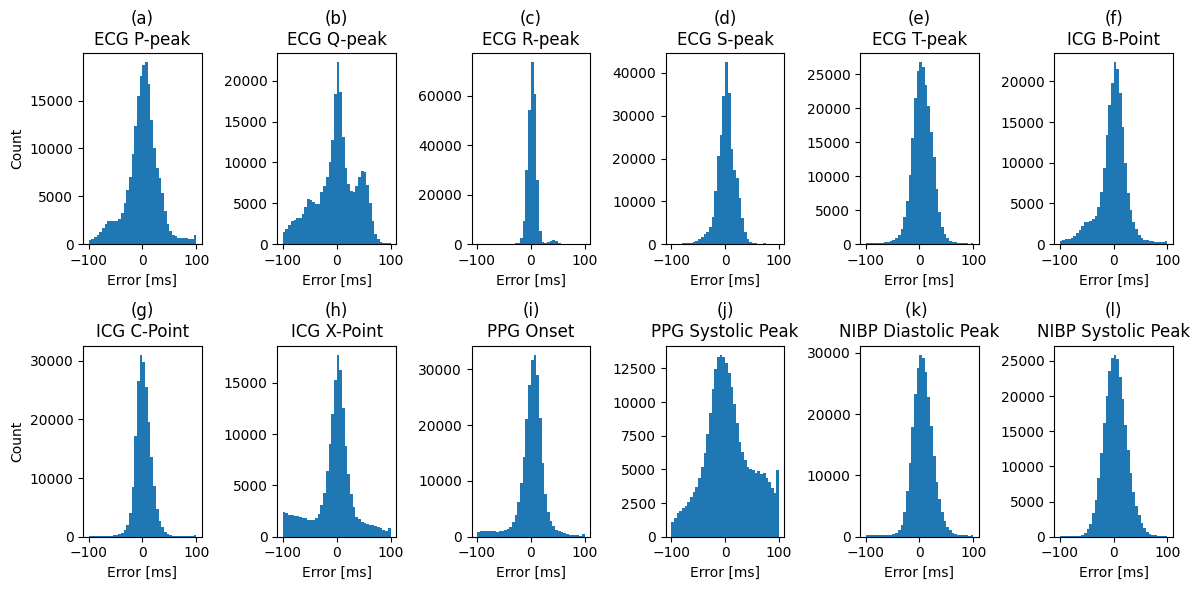

In [ ]:
plt.figure(figsize=(12,6))

plt.subplot(2,6,1)
plt.hist(5*(np.hstack(ppks_test_flat)-np.hstack(ppks_pred_flat)),range=(-100,100),bins=40)
plt.ylabel('Count')
plt.xlabel('Error [ms]')
plt.title('(a)\nECG P-peak')

plt.subplot(2,6,2)
plt.hist(5*(np.hstack(qpks_test_flat)-np.hstack(qpks_pred_flat)),range=(-100,100),bins=40)
plt.xlabel('Error [ms]')
plt.title('(b)\nECG Q-peak')

plt.subplot(2,6,3)
plt.hist(5*(np.hstack(rpks_test_flat)-np.hstack(rpks_pred_flat)),range=(-100,100),bins=40)
plt.xlabel('Error [ms]')
plt.title('(c)\nECG R-peak')

plt.subplot(2,6,4)
plt.hist(5*(np.hstack(spks_test_flat)-np.hstack(spks_pred_flat)),range=(-100,100),bins=40)
plt.xlabel('Error [ms]')
plt.title('(d)\nECG S-peak')

plt.subplot(2,6,5)
plt.hist(5*(np.hstack(tpks_test_flat)-np.hstack(tpks_pred_flat)),range=(-100,100),bins=40)
plt.xlabel('Error [ms]')
plt.title('(e)\nECG T-peak')

plt.subplot(2,6,6)
plt.hist(5*(np.hstack(bpks_test_flat)-np.hstack(bpks_pred_flat)),range=(-100,100),bins=40)
plt.xlabel('Error [ms]')
plt.title('(f)\nICG B-Point')


plt.subplot(2,6,7)
plt.hist(5*(np.hstack(cpks_test_flat)-np.hstack(cpks_pred_flat)),range=(-100,100),bins=40)
plt.ylabel('Count')
plt.xlabel('Error [ms]')
plt.title('(g)\nICG C-Point')

plt.subplot(2,6,8)
plt.hist(5*(np.hstack(xpks_test_flat)-np.hstack(xpks_pred_flat)),range=(-100,100),bins=40)
plt.xlabel('Error [ms]')
plt.title('(h)\nICG X-Point')


plt.subplot(2,6,9)
plt.hist(5*(np.hstack(d_ppg_test_flat)-np.hstack(d_ppg_pred_flat)),range=(-100,100),bins=40)
plt.title('(i)\nPPG Onset')
plt.xlabel('Error [ms]')

plt.subplot(2,6,10)
plt.hist(5*(np.hstack(s_ppg_test_flat)-np.hstack(s_ppg_pred_flat)),range=(-100,100),bins=40)
plt.title('(j)\nPPG Systolic Peak')
plt.xlabel('Error [ms]')

plt.subplot(2,6,11)
plt.hist(5*(np.hstack(d_nibp_test_flat)-np.hstack(d_nibp_pred_flat)),range=(-100,100),bins=40)
plt.title('(k) \nNIBP Diastolic Peak')
plt.xlabel('Error [ms]')

plt.subplot(2,6,12)
plt.hist(5*(np.hstack(s_nibp_test_flat)-np.hstack(s_nibp_pred_flat)),range=(-100,100),bins=40)
plt.title('(l)\nNIBP Systolic Peak')
plt.xlabel('Error [ms]')

plt.tight_layout()
plt.savefig(path_SAVE+'hist2.png',dpi=1000)
plt.show()

### Figure 7 - Window size

In [ ]:
rs_all = np.zeros((4,4))
maes_all = np.zeros((4,4))
n_windows = [512, 1024, 2048, 4096]
load_paths = [path_DATA_512+'saved_Data/2*',
              path_DATA_1024+'saved_Data/2*',
              path_DATA_2048+'saved_Data/2*',
              path_DATA_4096+'saved_Data/2*']

for i_window, path_now in enumerate(load_paths):
    y_pred_loaded = []
    y_test_loaded = []
    dfs_loaded = []
    files_load = glob.glob(path_now)
    str_cols = ['Sub_id', 'Day_id', 'Test_type', 'Test_num', 'Beat_num', 'ts_start','SBP', 'DBP', 'PP', 'MAP', 'File_id']
    for file_load in files_load:
        data_load = np.load(file_load,allow_pickle=True)
        y_pred_loaded.append(data_load['y_pred_test'])
        y_test_loaded.append(data_load['y_test'])
        dfs_loaded.append(pd.DataFrame(data=data_load['dfMeta_now'],columns=str_cols))

    # ECG, NIBP, ICG, PPG
    n_outputs = 4
    rs = []
    maes = []
    for k in range(20):
        r_test = np.zeros(n_outputs)
        mae_test = np.zeros(n_outputs)
        for i in range(n_outputs):
            r_test[i] = np.corrcoef(y_test_loaded[k][:,:,i].flatten(),y_pred_loaded[k][:,:,i].flatten())[0,1]
            mae_test[i] = mean_absolute_error(y_test_loaded[k][:,:,i],y_pred_loaded[k][:,:,i])
        rs.append(r_test)
        maes.append(mae_test)
        # print(k,r_test, r_test.mean())
    rs_all[i_window,:] = np.median(np.vstack(rs),axis=0)
    maes_all[i_window,:] = np.median(np.vstack(maes),axis=0)
    print(n_windows[i_window],np.median(np.vstack(rs),axis=0))

512 [0.80339507 0.91549801 0.83463272 0.92324155]
1024 [0.78701188 0.90444716 0.82433889 0.91984673]
2048 [0.79882908 0.89270614 0.81786982 0.9219226 ]
4096 [0.78852171 0.89084045 0.80997721 0.89848139]


In [4]:
maes_all

array([[0.3245186 , 0.27116823, 0.40460431, 0.25961409],
       [0.32623163, 0.29183016, 0.40456261, 0.26150879],
       [0.3173814 , 0.3042821 , 0.40516734, 0.28164836],
       [0.34035314, 0.33157514, 0.40420692, 0.31710787]])

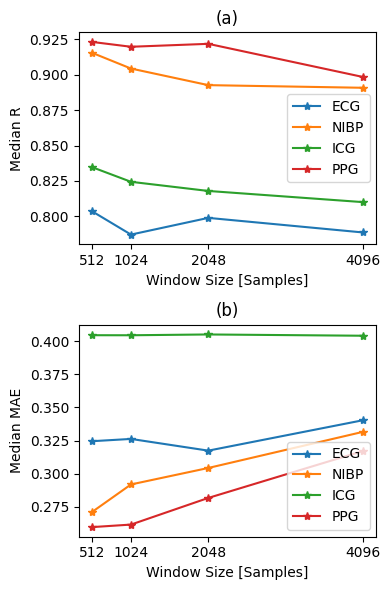

In [14]:
plt.figure(figsize=(4,6))
plt.subplot(2,1,1)
plt.plot(n_windows,rs_all[:,0],'-*')
plt.plot(n_windows,rs_all[:,1],'-*')
plt.plot(n_windows,rs_all[:,2],'-*')
plt.plot(n_windows,rs_all[:,3],'-*')
plt.xticks(n_windows)
plt.legend(['ECG', 'NIBP','ICG','PPG'])
plt.title('(a)')
plt.ylabel('Median R')
plt.xlabel('Window Size [Samples]')

plt.subplot(2,1,2)
plt.plot(n_windows,maes_all[:,0],'-*')
plt.plot(n_windows,maes_all[:,1],'-*')
plt.plot(n_windows,maes_all[:,2],'-*')
plt.plot(n_windows,maes_all[:,3],'-*')
plt.xticks(n_windows)
plt.legend(['ECG', 'NIBP','ICG','PPG'],loc='lower right')
plt.title('(b)')
plt.ylabel('Median MAE')
plt.xlabel('Window Size [Samples]')

plt.tight_layout()

plt.savefig('results_window_size.png',format='png',dpi=800)
plt.show()

### Figure 1 Waveforms

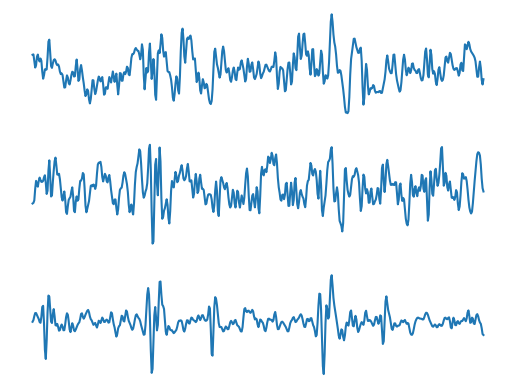

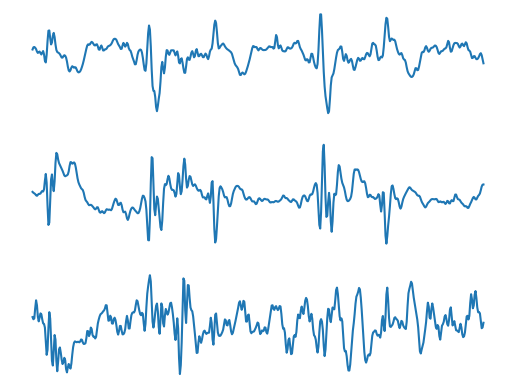

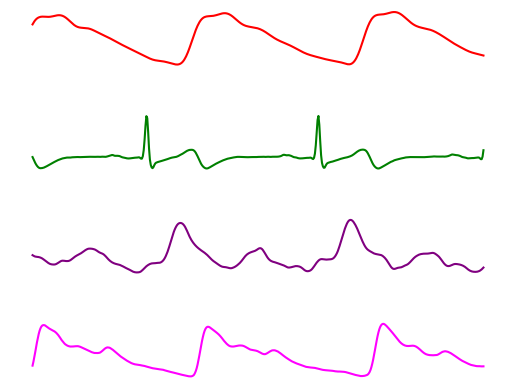

In [ ]:
i_beat = 117184
data_plot = data[i_beat]
for i_axis in range(3):
    ax_now = plt.subplot(3,1,i_axis+1)
    plt.plot(data_plot[:,i_axis])
    plt.axis('off')
plt.show()

for i_axis in range(3):
    ax_now = plt.subplot(3,1,i_axis+1)
    plt.plot(data[i_beat,:,i_axis+3])
    plt.axis('off')
plt.show()

bio_labels = ['PPG','ECG','ICG','NIBP']
bio_colors = ['red','green','purple','fuchsia']

bio_order = [2,0,1,3]
for i_subplot,i_axis in enumerate(bio_order):
    ax_now = plt.subplot(4,1,i_subplot+1)
    plt.plot(data_bio[i_beat,:,i_axis],color=bio_colors[i_subplot])
    plt.axis('off')

plt.subplots_adjust(hspace=0.8)
plt.show()


### Figure 3 Waveforms

In [ ]:
i_sub_arch = 11
i_beat_arch = 2073

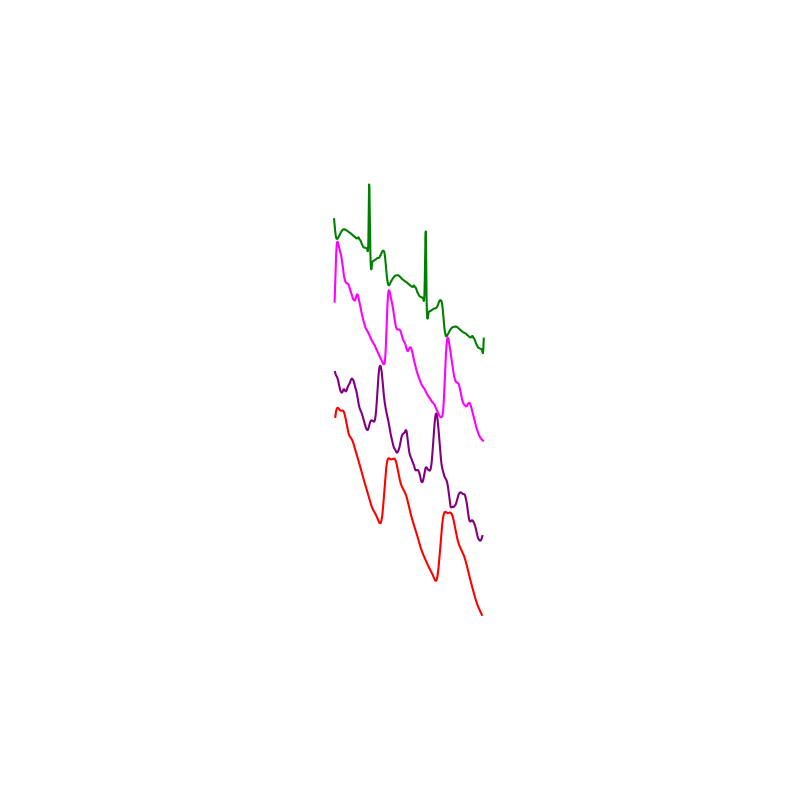

In [ ]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
x = np.linspace(0,1,512)
target_signal = y_test_loaded[i_sub_arch][i_beat_arch,:,:]
target_signal = (target_signal - target_signal.min(axis=0)) / (target_signal.max(axis=0) - target_signal.min(axis=0))

bio_colors = ['green','fuchsia','purple','red']
shifts = [3,2,1,0]
for i,shift in enumerate(shifts):
    ax.plot(x,target_signal[:,i]+shift, zs=0,zdir='y',color=bio_colors[i])
ax.view_init(elev=20,azim=-20,roll=0)
# ax.set_zlim(0,2)
plt.axis('off')
plt.savefig(path_SAVE+'y_test_tilted2.png',dpi=1000,transparent=True)
plt.show()

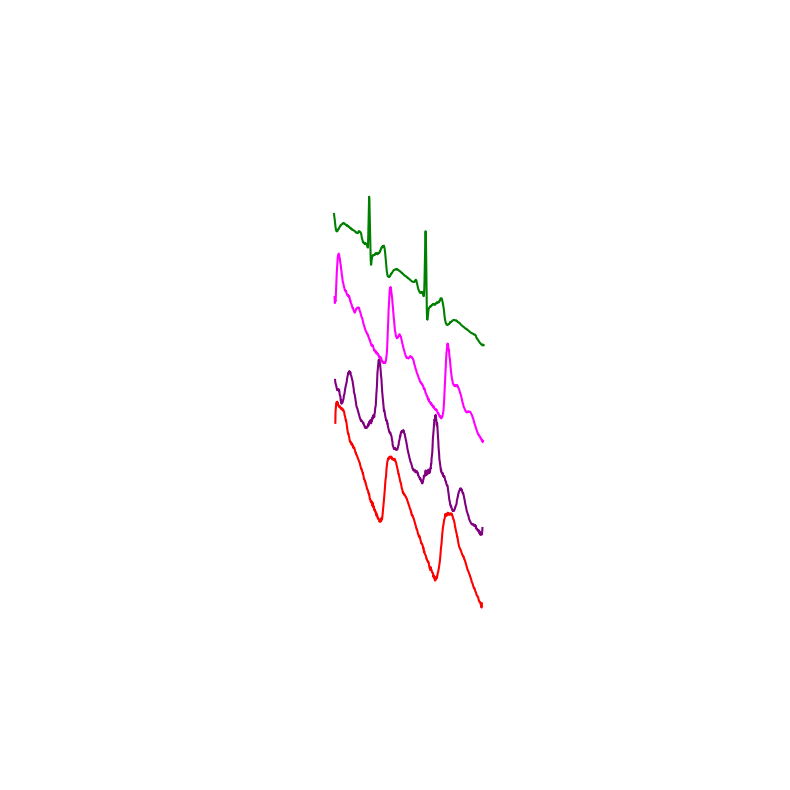

In [ ]:
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
x = np.linspace(0,1,512)
target_signal = y_pred_loaded[i_sub_arch][i_beat_arch,:,:]
target_signal = (target_signal - target_signal.min(axis=0)) / (target_signal.max(axis=0) - target_signal.min(axis=0))

bio_colors = ['green','fuchsia','purple','red']
shifts = [3,2,1,0]
for i,shift in enumerate(shifts):
    ax.plot(x,target_signal[:,i]+shift, zs=0,zdir='y',color=bio_colors[i])
ax.view_init(elev=20,azim=-20,roll=0)

plt.axis('off')
plt.savefig(path_SAVE+'y_pred_tilted2.png',dpi=1000,transparent=True)
plt.show()

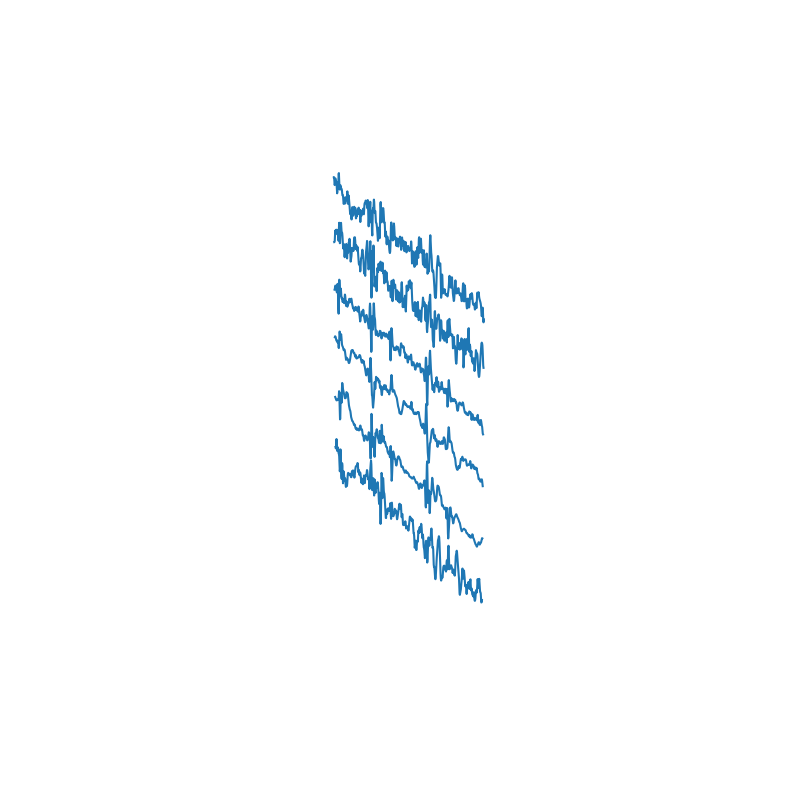

In [ ]:
i_beat = 117184

ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
x = np.linspace(0,1,512)

target_signal = data[i_beat]
target_signal = (target_signal - target_signal.min(axis=0)) / (target_signal.max(axis=0) - target_signal.min(axis=0))

shifts = [5,4,3,2,1,0]
for i,shift in enumerate(shifts):
    ax.plot(x,target_signal[:,i]+shift, zs=0,zdir='y',color='#1f77b4')
ax.view_init(elev=20,azim=-20,roll=0)

plt.axis('off')
plt.savefig(path_SAVE+'vcg_tilted2.png',dpi=1000,transparent=True)
# plt.show()

## Train on entire data and save final model

In [ ]:
n_epochs = 5
batch_size = 32
x_train, x_test, y_train, y_test, params = split_data(data, 
                                                    np.concatenate((np.expand_dims(data_bio[:,:,0],axis=2),np.expand_dims(data_bio[:,:,3],axis=2),np.expand_dims(data_bio[:,:,1],axis=2),np.expand_dims(data_bio[:,:,2],axis=2)),axis=2),
                                                    dfMeta,split_type='loo',sub_num = [0],
                                                    normalize_inputs=True, normalize_outputs = True, 
                                                    normalize_output_beats=True,
                                                    normalize_input_beats=True
                                                    )
x_train.shape
x_train = np.concatenate([x_train,x_test])
y_train = np.concatenate([y_train,y_test])
dataset_p2p = CustomDataset(x_train,y_train,batch_size=batch_size)

input_shape = x_train[0].shape
target_shape = y_train[0].shape
output_channels = target_shape[1]  # Example output channels

generator = pix2pix_generator_1d_8(input_shape, output_channels)
discriminator = pix2pix_discriminator_1d(input_shape, target_shape)

gan_model = pix2pix_model(generator=generator,discriminator=discriminator)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

gan_model.compile(d_optimizer = discriminator_optimizer,g_optimizer = generator_optimizer,d_loss_fn = discriminator_loss,g_loss_fn = generator_loss)
hist = gan_model.fit(dataset_p2p,epochs=n_epochs)


In [ ]:
gan_model.save_weights(path_SAVE+'saved_weights.h5')

In [ ]:
# Example usage for loading model weights

input_shape = x_train[0].shape
target_shape = y_train[0].shape
output_channels = target_shape[1]

generator = pix2pix_generator_1d_8(input_shape, output_channels)
discriminator = pix2pix_discriminator_1d(input_shape, target_shape)

gan_model_saved = pix2pix_model(generator=generator,discriminator=discriminator)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

gan_model_saved.compile(d_optimizer = discriminator_optimizer,g_optimizer = generator_optimizer,d_loss_fn = discriminator_loss,g_loss_fn = generator_loss)
_ = gan_model_saved((tf.random.normal([1, 512, 6]),tf.random.normal([1, 512, 4])))

gan_model_saved.load_weights(path_SAVE+'saved_weights.h5')